In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Learning to learn with quantum neural networks
==============================================

::: {.meta}
:property=\"og:description\": Use a classical recurrent neural network
to initilize the parameters of a variational quatum algorithm.
:property=\"og:image\": ../demonstrations/learning2learn/thumbnail.png
:::

::: {.related}
tutorial\_qaoa\_intro Intro to QAOA tutorial\_qaoa\_maxcut QAOA for
MaxCut problem
:::

*Author: Stefano Mangini --- Posted: 02 March 2021. Last updated: 15
September 2021.*

In this demo we recreate the architecture proposed in *Learning to learn
with quantum neural networks via classical neural networks*, using
**PennyLane** and **TensorFlow**. We use classical recurrent neural
networks to assist the optimization of variational quantum algorithms.

We start with a brief theoretical overview explaining the problem and
the setup used to solve it. After that, we deep dive into the code to
build a fully functioning model, ready to be further developed or
customized for your own needs. Without further ado, let's begin!

Problem: Optimization of Variational Quantum Algorithms
-------------------------------------------------------

Recently, a big effort by the quantum computing community has been
devoted to the study of variational quantum algorithms (VQAs) which
leverage quantum circuits with fixed shape and tunable parameters. The
idea is similar to classical neural networks, where the weights of the
network are optimized during training. Similarly, once the shape of the
variational quantum circuit is chosen --- something that is very
difficult and sensitive to the particular task at hand --- its tunable
parameters are optimized iteratively by minimizing a cost (or loss)
function, which measures how good the quantum algorithm is performing
(see for a thorough overview on VQAs).

A major challenge for VQAs relates to the optimization of tunable
parameters, which was shown to be a very hard task, . Parameter
initialization plays a key role in this scenario, since initializing the
parameters in the proximity of an optimal solution leads to faster
convergence and better results. Thus, a good initialization strategy is
crucial to promote the convergence of local optimizers to local extrema
and to select reasonably good local minima. By local optimizer, we mean
a procedure that moves from one solution to another by small (local)
changes in parameter space. These are opposed to global search methods,
which take into account large sections of parameter space to propose a
new solution.

One such strategy could come from the classical machine learning
literature.

Solution: Classical Recurrent Neural Networks
---------------------------------------------

By building on results from the *meta-learning* literature in machine
learning, authors in propose to use a Recurrent Neural Network (RNN) as
a black-box controller to optimize the parameters of variational quantum
algorithms, as shown in the figure below. The cost function used is the
expectation value
$\langle H \rangle_{\boldsymbol{\theta}} = \langle \psi_{\boldsymbol{\theta}} | H | \psi_{\boldsymbol{\theta}}\rangle$
of a Hamiltonian $H$ with respect to the parametrized state
$|\psi_\boldsymbol{\theta}\rangle$ evolved by applying the variational
quantum circuit to the zero state $|00\cdots0\rangle$.

![](../demonstrations/learning2learn/HybridLSTM.png){.align-center
width="100.0%"}

Given parameters $\boldsymbol{\theta}_{t-1}$ of the variational quantum
circuit, the cost function $y_{t-1}$, and the hidden state of the
classical network $\boldsymbol{h}_{t-1}$ at the previous time step, the
recurrent neural network proposes a new guess for the parameters
$\boldsymbol{\theta}_t$, which are then fed into the quantum computer to
evaluate the cost function $y_t$. By repeating this cycle a few times,
and by training the weights of the recurrent neural network to minimize
the loss function $y_t$, a good initialization heuristic is found for
the parameters $\boldsymbol{\theta}$ of the variational quantum circuit.

At a given iteration, the RNN receives as input the previous cost
function $y_t$ evaluated on the quantum computer, where $y_t$ is the
estimate of $\langle H\rangle_{t}$, as well as the parameters
$\boldsymbol{\theta}_t$ for which the variational circuit was evaluated.
The RNN at this time step also receives information stored in its
internal hidden state from the previous time step $\boldsymbol{h}_t$.
The RNN itself has trainable parameters $\phi$, and hence it applies the
parametrized mapping:

$$\boldsymbol{h}_{t+1}, \boldsymbol{\theta}_{t+1} = \text{RNN}_{\phi}(\boldsymbol{h}_{t}, \boldsymbol{\theta}_{t}, y_{t}),$$

which generates a new suggestion for the variational parameters as well
as a new internal state. Upon training the weights $\phi$, the RNN
eventually learns a good heuristic to suggest optimal parameters for the
quantum circuit.

Thus, by training on a dataset of graphs, the RNN can subsequently be
used to provide suggestions for starting points on new graphs! We are
not directly optimizing the variational parameters of the quantum
circuit, but instead, we let the RNN figure out how to do that. In this
sense, we are learning (training the RNN) how to learn (how to optimize
a variational quantum circuit).

**VQAs in focus: QAOA for MaxCut**

There are multiple VQAs for which this hybrid training routine could be
used, some of them directly analyzed in. In the following, we focus on
one such example, the Quantum Approximate Optimization Algorithm (QAOA)
for solving the MaxCut problem. Thus, referring to the picture above,
the shape of the variational circuit is the one dictated by the QAOA
ansatz, and such a quantum circuit is used to evaluate the cost
Hamiltonian $H$ of the MaxCut problem. Check out this great tutorial on
how to use QAOA for solving graph problems:
<https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html>

::: {.note}
::: {.title}
Note
:::

Running the tutorial (excluding the Appendix) requires approx. \~13m.
:::


**Importing the required packages**

During this tutorial, we will use **PennyLane** for executing quantum
circuits and for integrating seamlessly with **TensorFlow**, which will
be used for creating the RNN.


In [2]:
#!pip install tensorflow

In [3]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

2023-12-08 16:14:13.808335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 16:14:13.808416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 16:14:13.945715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 16:14:16.915426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generation of training data: graphs
===================================

The first step is to gather or create a good dataset that will be used
to train the model and test its performance. In our case, we are
analyzing MaxCut, which deals with the problem of finding a good binary
partition of nodes in a graph such that the number of edges *cut* by
such a separation is maximized. We start by generating some random
graphs $G_{n,p}$ where:

-   $n$ is the number of nodes in each graph,
-   $p$ is the probability of having an edge between two nodes.


In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

An example of a random graph generated using the function
`generate_graphs` just defined:


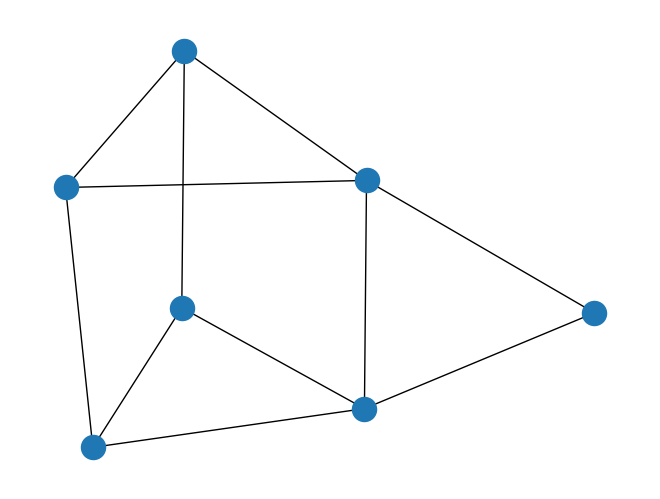

In [5]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

![](../demonstrations/learning2learn/rendered_Graph0.png){.align-center
width="70.0%"}


Variational Quantum Circuit: QAOA
=================================

Now that we have a dataset, we move on by creating the QAOA quantum
circuits using PennyLane's built-in sub-packages. In particular, using
PennyLane's `qaoa` module, we will able to create fully functioning
quantum circuits for the MaxCut problem, with very few lines of code.


In [6]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        n_shots=2000
        n_qubits=len(graph.nodes)
        #dev = qml.device("lightning.qubit", wires=tot_qubits)
        #dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', wires=n_qubits, shots=n_shots)
        #dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:::device/quantum-simulator/amazon/sv1', wires=n_qubits, shots=n_shots)
        #dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:::device/quantum-simulator/amazon/tn1', wires=n_qubits, shots=n_shots)
        dev = qml.device("default.qubit.tf", wires=n_qubits)
        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, diff_method="backprop")

        return cost(params)

    return hamiltonian

Before continuing, let's see how to use these functions.


In [7]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

2023-12-08 16:14:56.611067: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


tf.Tensor(-3.1932679572555784, shape=(), dtype=float64)


::: {.rst-class}
sphx-glr-script-out

``` {.none}
tf.Tensor(-3.193267957255582, shape=(), dtype=float64)
```
:::


Recurrent Neural Network: LSTM
==============================

So far, we have defined the machinery which lets us build the QAOA
algorithm for solving the MaxCut problem. Now we wish to implement the
Recurrent Neural Network architecture explained previously. As proposed
in the original paper, we will build a custom model of a Long-Short Term
Memory (LSTM) network, capable of handling the hybrid data passing
between classical and quantum procedures. For this task, we will use
`Keras` and `TensorFlow`.


First of all, let's define the elemental building block of the model, an
LSTM cell (see [TensorFlow
documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell)
for further details).


In [8]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

Using the `qaoa_from_graph` function, we create a list `graph_cost_list`
containing the cost functions of a set of graphs. You can see this as a
preprocessing step of the data.


In [9]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

At this stage, we seek to reproduce the recurrent behavior depicted in
the picture above, outlining the functioning of an RNN as a black-box
optimizer. We do so by defining two functions:

-   `rnn_iteration`: accounts for the computations happening on a single
    time step in the figure. It performs the calculation inside the CPU
    and evaluates the quantum circuit on the QPU to obtain the loss
    function for the current parameters.
-   `recurrent_loop`: as the name suggests, it accounts for the creation
    of the recurrent loop of the model. In particular, it makes
    consecutive calls to the `rnn_iteration` function, where the outputs
    of a previous call are fed as inputs of the next call.


In [10]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

**The cost function**

A key part in the `recurrent_loop` function is given by the definition
of the variable `loss`. In order to drive the learning procedure of the
weights in the LSTM cell, a cost function is needed. While in the
original paper the authors suggest using a measure called *observed
improvement*, for simplicity here we use an easier cost function
$\cal{L}(\phi)$ defined as:

$$\cal{L}(\phi) = {\bf w} \cdot {\bf y}_t(\phi),$$

where ${\bf y}_t(\phi) = (y_1, \cdots, y_5)$ contains the Hamiltonian
cost functions from all iterations, and ${\bf w}$ are just some
coefficients weighting the different steps in the recurrent loop. In
this case, we used ${\bf w}=\frac{1}{5} (0.1, 0.2, 0.3, 0.4, 0.5)$, to
give more importance to the last steps rather than the initial steps.
Intuitively in this way the RNN is more free (low coefficient) to
explore a larger portion of parameter space during the first steps of
optimization, while it is constrained (high coefficient) to select an
optimal solution towards the end of the procedure. Note that one could
also use just the final cost function from the last iteration to drive
the training procedure of the RNN. However, using values also from
intermediate steps allows for a smoother suggestion routine, since even
non-optimal parameter suggestions from early steps are penalized using
$\cal{L}(\phi)$.


**Training**

Now all the cards are on the table and we just need to prepare a
training routine and then run it!

First of all, let's wrap a single gradient descent step inside a custom
function `train_step`.


In [11]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

We are now ready to start the training. In particular, we will perform a
stochastic gradient descent in the parameter space of the weights of the
LSTM cell. For each graph in the training set, we evaluate gradients and
update the weights accordingly. Then, we repeat this procedure for
multiple times (epochs).

::: {.note}
::: {.title}
Note
:::

Be careful when using bigger datasets or training for larger epochs,
this may take a while to execute.
:::


In [12]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -1.6566956043243408
 > Graph 6/20 - Loss: -1.429755449295044
 > Graph 11/20 - Loss: -1.3686835765838623
 > Graph 16/20 - Loss: -1.2627522945404053
 >> Mean Loss during epoch: -1.7317298531532288
Epoch 2
 > Graph 1/20 - Loss: -2.117368698120117
 > Graph 6/20 - Loss: -1.4593784809112549
 > Graph 11/20 - Loss: -1.3932359218597412
 > Graph 16/20 - Loss: -1.2969133853912354
 >> Mean Loss during epoch: -1.8280356705188752
Epoch 3
 > Graph 1/20 - Loss: -2.1410841941833496
 > Graph 6/20 - Loss: -1.4674417972564697
 > Graph 11/20 - Loss: -1.3887748718261719
 > Graph 16/20 - Loss: -1.3127374649047852
 >> Mean Loss during epoch: -1.8349558234214782
Epoch 4
 > Graph 1/20 - Loss: -2.1432254314422607
 > Graph 6/20 - Loss: -1.4736167192459106
 > Graph 11/20 - Loss: -1.3894761800765991
 > Graph 16/20 - Loss: -1.3123594522476196
 >> Mean Loss during epoch: -1.8364510238170624
Epoch 5
 > Graph 1/20 - Loss: -2.14227032661438
 > Graph 6/20 - Loss: -1.4757719039916992
 > Graph

::: {.rst-class}
sphx-glr-script-out

``` {.none}
Epoch 1
 > Graph 1/20 - Loss: -1.6641689538955688
 > Graph 6/20 - Loss: -1.4186843633651733
 > Graph 11/20 - Loss: -1.3757232427597046
 > Graph 16/20 - Loss: -1.294339656829834
 >> Mean Loss during epoch: -1.7352586269378663
Epoch 2
 > Graph 1/20 - Loss: -2.119091749191284
 > Graph 6/20 - Loss: -1.4789190292358398
 > Graph 11/20 - Loss: -1.3779840469360352
 > Graph 16/20 - Loss: -1.2963457107543945
 >> Mean Loss during epoch: -1.8252217948436738
Epoch 3
 > Graph 1/20 - Loss: -2.1322619915008545
 > Graph 6/20 - Loss: -1.459418535232544
 > Graph 11/20 - Loss: -1.390620470046997
 > Graph 16/20 - Loss: -1.3165746927261353
 >> Mean Loss during epoch: -1.8328069806098939
Epoch 4
 > Graph 1/20 - Loss: -2.1432175636291504
 > Graph 6/20 - Loss: -1.476362943649292
 > Graph 11/20 - Loss: -1.3938289880752563
 > Graph 16/20 - Loss: -1.3140206336975098
 >> Mean Loss during epoch: -1.8369774043560028
Epoch 5
 > Graph 1/20 - Loss: -2.1429405212402344
 > Graph 6/20 - Loss: -1.477513074874878
 > Graph 11/20 - Loss: -1.3909202814102173
 > Graph 16/20 - Loss: -1.315887689590454
 >> Mean Loss during epoch: -1.8371947884559632
```
:::


As you can see, the Loss for each graph keeps decreasing across epochs,
indicating that the training routine is working correctly.


Results
=======

Let's see how to use the optimized RNN as an initializer for the angles
in the QAOA algorithm.

First, we pick a new graph, not present in the training dataset:


In [ ]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

![](../demonstrations/learning2learn/rendered_Graph1.png){.align-center
width="70.0%"}


Then we apply the trained RNN to this new graph, saving intermediate
results coming from all the recurrent iterations in the network.


In [ ]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

**Plot of the loss function**

We can plot these losses to see how well the RNN proposes new guesses
for the parameters.


In [ ]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossLSTM.png){.align-center
width="70.0%"}

That's remarkable! The RNN learned to propose new parameters such that
the MaxCut cost is minimized very rapidly: in just a few iterations the
loss reaches a minimum. Actually, it takes just a single step for the
LSTM to find a very good minimum. In fact, due to the recurrent loop,
the loss in each time step is directly dependent on the previous ones,
with the first iteration thus having a lot of influence on the loss
function defined above. Changing the loss function, for example giving
less importance to initial steps and just focusing on the last one,
leads to different optimization behaviors, but with the same final
results.


**Comparison with standard Stochastic Gradient Descent (SGD)**

How well does this method compare with standard optimization techniques,
for example, leveraging Stochastic Gradient Descent (SGD) to optimize
the parameters in the QAOA?

Let's check it out.


In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

::: {.rst-class}
sphx-glr-script-out

``` {.none}
Step 1 - Loss = -4.1700805
Step 2 - Loss = -4.67503588
Step 3 - Loss = -5.09949909
Step 4 - Loss = -5.40388533
Step 5 - Loss = -5.59529203
Step 6 - Loss = -5.70495197
Step 7 - Loss = -5.7642561
Step 8 - Loss = -5.79533198
Step 9 - Loss = -5.81138752
Step 10 - Loss = -5.81966529
Step 11 - Loss = -5.82396722
Step 12 - Loss = -5.82624537
Step 13 - Loss = -5.82749126
Step 14 - Loss = -5.82820626
Step 15 - Loss = -5.82864379
Final cost function: -5.828932361904984
Optimized angles: [[ 0.5865477 ]
 [-0.3228858]]
```
:::


In [ ]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossConfrontation.png){.align-center
width="70.0%"}


*Hurray!* 🎉🎉

As is clear from the picture, the RNN reaches a better minimum in fewer
iterations than the standard SGD. Thus, as the authors suggest, the
trained RNN can be used for a few iterations at the start of the
training procedure to initialize the parameters of the quantum circuit
close to an optimal solution. Then, a standard optimizer like the SGD
can be used to fine-tune the proposed parameters and reach even better
solutions. While on this small scale example the benefits of using an
LSTM to initialize parameters may seem modest, on more complicated
instances and problems it can make a big difference, since, on random
initialization of the parameters, standard local optimizer may encounter
problems finding a good minimization direction (for further details,
see,).


Final remarks
=============

In this demo, we saw how to use a recurrent neural network as a
black-box optimizer to initialize the parameters in a variational
quantum circuit close to an optimal solution. We connected MaxCut QAOA
quantum circuits in PennyLane with an LSTM built with TensorFlow, and we
used a custom hybrid training routine to optimize the whole network.

Such architecture proved itself to be a good candidate for the
initialization problem of Variational Quantum Algorithms, since it
reaches good optimal solutions in very few iterations. Besides, the
architecture is quite general since the same machinery can be used for
graphs having a generic number of nodes (see \"Generalization
Performances\" in the Appendix).

**What's next?**

But the story does not end here. There are multiple ways this work could
be improved. Here are a few:

-   Use the proposed architecture for VQAs other than QAOA for MaxCut.
    You can check the paper to get some inspiration.
-   Scale up the simulation, using bigger graphs and longer recurrent
    loops.
-   While working correctly, the training routine is quite basic and it
    could be improved for example by implementing batch learning or a
    stopping criterion. Also, one could implement the *observed
    improvement* loss function, as used in the original paper .
-   Depending on the problem, you may wish to transform the functions
    `rnn_iteration` and `recurrent_loop` to actual `Keras Layers` and
    `Models`. This way, by compiling the model before the training takes
    place, `TensorFlow` can create the computational graph of the model
    and train more efficiently. You can find some ideas below to start
    working on it.

If you\'re interested, in the Appendix below you can find some more
details and insights about this model. Go check it out!

If you have any doubt, or wish to discuss about the project don't
hesitate to contact me, I'll be very happy to help you as much as I can
😁

Have a great quantum day!


References
==========


Appendix
========

In this appendix you can find further details about the Learning to
Learn approach introduced in this tutorial.

Generalization performances
---------------------------

A very interesting feature of this model, is that it can be
straightforwardly applied to graphs having a different number of nodes.
In fact, until now our analysis focused only on graphs with the same
number of nodes for ease of explanation, and there is no actual
restriction in this respect. The same machinery works fine for any
graph, since the number of QAOA parameters are only dependent on the
number of layers in the ansatz, and not on the number of qubits (equal
to the number of nodes in the graph) in the quantum circuit.

Thus, we might want to challenge our model to learn a good
initialization heuristic for a non-specific graph, with an arbitrary
number of nodes. For this purpose, let's create a training dataset
containing graphs with a different number of nodes $n$, taken in the
interval $n \in [7,9]$ (that is, our dataset now contains graphs having
either 7, 8 and 9 nodes).


In [ ]:
cell = tf.keras.layers.LSTMCell(2 * n_layers)

g7 = generate_graphs(5, 7, 3 / 7)
g8 = generate_graphs(5, 8, 3 / 7)
g9 = generate_graphs(5, 9, 3 / 7)

gs = g7 + g8 + g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

# Shuffle the dataset
import random
random.seed(1234)
random.shuffle(gs_cost_list)

So far, we have created an equally balanced dataset that contains graphs
with a different number of nodes. We now use this dataset to train the
LSTM.


In [ ]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

::: {.rst-class}
sphx-glr-script-out

``` {.none}
Epoch 1
> Graph 1/15 - Loss: [[-1.4876363]]
> Graph 6/15 - Loss: [[-1.8590403]]
> Graph 11/15 - Loss: [[-1.7644017]]
>> Mean Loss during epoch: -1.9704322338104248
Epoch 2
> Graph 1/15 - Loss: [[-1.8650053]]
> Graph 6/15 - Loss: [[-1.9578737]]
> Graph 11/15 - Loss: [[-1.8377447]]
>> Mean Loss during epoch: -2.092947308222453
Epoch 3
> Graph 1/15 - Loss: [[-1.9009062]]
> Graph 6/15 - Loss: [[-1.9726204]]
> Graph 11/15 - Loss: [[-1.8668792]]
>> Mean Loss during epoch: -2.1162660201390584
```
:::


Let's check if this hybrid model eventually learned a good heuristic to
propose new updates for the parameters in the QAOA ansatz of the MaxCut
problem.

For this reason, we consider a new graph. In particular, we can take a
graph with 10 nodes, which is something that the recurrent network has
not seen before.


In [ ]:
new_graph = nx.gnp_random_graph(10, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

![](../demonstrations/learning2learn/rendered_Graph10.png){.align-center
width="70.0%"}


We call the trained recurrent LSTM on this graph, saving not only the
last, but all intermediate guesses for the parameters.


In [ ]:
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

![](../demonstrations/learning2learn/rendered_LossGeneralization.png){.align-center
width="70.0%"}


Again, we can confirm that the custom optimizer based on the LSTM
quickly reaches a good value of the loss function, and also achieve good
generalization performances, since it is able to initialize parameters
also for graphs not present in the training set.

::: {.note}
::: {.title}
Note
:::

To get the optimized weights of the LSTM use:
`optimized_weights = cell.get_weights()`. To set initial weights for the
LSTM cell, use instead: `cell.set_weights(optimized_weights)`.
:::

Loss landscape in parameter space
=================================

It may be interesting to plot the path suggested by the RNN in the space
of the parameters. Note that this is possible only if one layer is used
in the QAOA ansatz since in this case only two angles are needed and
they can be plotted on a 2D plane. Of course, if more layers are used,
you can always select a pair of them to reproduce a similar plot.

::: {.note}
::: {.title}
Note
:::

This cell takes approx. \~1m to run with an 11 by 11 grid
:::


In [ ]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1.0, 1.0, 11)
dz = np.array([new_cost([[xx], [yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.0] + [res[i].numpy()[0, 0] for i in range(len(res[:-1]))]
params_y = [0.0] + [res[i].numpy()[0, 1] for i in range(len(res[:-1]))]

# Plot steps
plt.plot(params_x, params_y, linestyle="--", color="red", marker="x")

plt.yticks(np.linspace(-1, 1, 5))
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\gamma$", fontsize=12)
plt.title("Loss Landscape", fontsize=12)
plt.show()

![](../demonstrations/learning2learn/rendered_LossLandscape.png){.align-center
width="70.0%"}

Ideas for creating a Keras Layer and Keras Model
================================================

Definition of a `Keras Layer` containing a single pass through the LSTM
and the Quantum Circuit. That's equivalent to the function
`rnn_iteration` from before.


In [ ]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p=1, graph=None):
        super(QRNN, self).__init__()
        # p is the number of layers in the QAOA ansatz
        self.cell = tf.keras.layers.LSTMCell(2 * p)
        self.expectation = qaoa_from_graph(graph, n_layers=p)
        self.qaoa_p = p

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]

        # Concatenate the previous parameters and previous cost to create new input
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

        # New parameters obtained by the LSTM cell, along with new internal states h and c
        new_params, [new_h, new_c] = self.cell(new_input, states=[prev_h, prev_c])

        # This part is used to feed the parameters to the PennyLane function
        _params = tf.reshape(new_params, shape=(2, self.qaoa_p))

        # Cost evaluation, and reshaping to be consistent with other Keras tensors
        new_cost = tf.reshape(tf.cast(self.expectation(_params), dtype=tf.float32), shape=(1, 1))

        return [new_cost, new_params, new_h, new_c]

Code for creating an actual `Keras Model` starting from the previous
layer definition.


In [ ]:
_graph = nx.gnp_random_graph(7, p=3 / 7)

# Instantiate the LSTM cells
rnn0 = QRNN(graph=_graph)

# Create some input layers to feed the data
inp_cost = tf.keras.layers.Input(shape=(1,))
inp_params = tf.keras.layers.Input(shape=(2,))
inp_h = tf.keras.layers.Input(shape=(2,))
inp_c = tf.keras.layers.Input(shape=(2,))

# Manually creating the recurrent loops. In this case just three iterations are used.
out0 = rnn0([inp_cost, inp_params, inp_h, inp_c])
out1 = rnn0(out0)
out2 = rnn0(out1)

# Definition of a loss function driving the training of the LSTM
loss = tf.keras.layers.average([0.15 * out0[0], 0.35 * out1[0], 0.5 * out2[0]])

# Definition of a Keras Model
model = tf.keras.Model(
    inputs=[inp_cost, inp_params, inp_h, inp_c], outputs=[out0[1], out1[1], out2[1], loss]
)

model.summary()

::: {.rst-class}
sphx-glr-script-out

``` {.none}
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to
==================================================================================================
input_1 (InputLayer)            [(None, 1)]          0
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0
__________________________________________________________________________________________________
qrnn (QRNN)                     [(1, 1),             48         input_1[0][0]
                                 (None, 2),                     input_2[0][0]
                                 (None, 2),                     input_3[0][0]
                                 (None, 2)]                     input_4[0][0]
                                                                qrnn[0][0]
                                                                qrnn[0][1]
                                                                qrnn[0][2]
                                                                qrnn[0][3]
                                                                qrnn[1][0]
                                                                qrnn[1][1]
                                                                qrnn[1][2]
                                                                qrnn[1][3]
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (1, 1)               0           qrnn[0][0]
__________________________________________________________________________________________________
tf.math.multiply_1 (TFOpLambda) (1, 1)               0           qrnn[1][0]
__________________________________________________________________________________________________
tf.math.multiply_2 (TFOpLambda) (1, 1)               0           qrnn[2][0]
__________________________________________________________________________________________________
average_147 (Average)           (1, 1)               0           tf.math.multiply[0][0]
                                                                tf.math.multiply_1[0][0]
                                                                tf.math.multiply_2[0][0]
==================================================================================================
Total params: 48
Trainable params: 48
Non-trainable params: 0
```
:::


A basic training routine for the `Keras Model` just created:


In [ ]:
p = 1

inp_costA = tf.zeros(shape=(1, 1))
inp_paramsA = tf.zeros(shape=(1, 2 * p))
inp_hA = tf.zeros(shape=(1, 2 * p))
inp_cA = tf.zeros(shape=(1, 2 * p))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 5

for _ in range(step):
    with tf.GradientTape() as tape:
        pred = model(inputs)
        loss = pred[3]

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    print(
        f"Step {_+1} - Loss = {loss} - Cost = {qaoa_from_graph(_graph, n_layers=p)(np.reshape(pred[2].numpy(),(2, p)))}"
    )

print("Final Loss:", loss.numpy())
print("Final Outs:")
for t, s in zip(pred, ["out0", "out1", "out2", "Loss"]):
    print(f" >{s}: {t.numpy()}")

::: {.rst-class}
sphx-glr-script-out

``` {.none}
Step 1 - Loss = [[-1.5563084]] - Cost = -4.762684301954701
Step 2 - Loss = [[-1.5649065]] - Cost = -4.799981173473755
Step 3 - Loss = [[-1.5741502]] - Cost = -4.840036354736862
Step 4 - Loss = [[-1.5841404]] - Cost = -4.883246647056216
Step 5 - Loss = [[-1.5948243]] - Cost = -4.929228976649736
Final Loss: [[-1.5948243]]
Final Outs:
>out0: [[-0.01041588  0.01016874]]
>out1: [[-0.04530389  0.38148248]]
>out2: [[-0.10258182  0.4134117 ]]
>Loss: [[-1.5948243]]
```
:::


::: {.note}
::: {.title}
Note
:::

This code works only for a single graph at a time, since a graph was
needed to create the `QRNN` `Keras Layer` named `rnn0`. Thus, in order
to actually train the RNN network for multiple graphs, the above
training routine must be modified. Otherwise, you could find a way to
define the model to accept as input a whole dataset of graphs, and not
just a single one. Still, this might prove particularly hard, since
TensorFlow deals with tensors, and is not able to directly manage other
data structures, like graphs or functions taking graphs as input, like
`qaoa_from_graph`.
:::

About the author
================
